# Setup

In [1]:
import matplotlib.pyplot as plt
from math import floor

import numpy as np
import scipy.io as sio
import pandas as pd

In [2]:
import glob
import os
import re

import itertools

from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.model_selection import cross_val_score

import pylab
plt.rcParams['figure.figsize'] = [15, 5]
%matplotlib inline

To allow interaction:

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

A useful toggle-code cell will help make this notebook tidier.

In [4]:
from IPython.display import HTML

In [22]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()"><h1>Toggle Code Visibility</h1></a>.''')

Load the processed data below to skip the preprocessing steps.

In [5]:
with pd.HDFStore('../data/processed/ddata.h5') as store:
    ddata = store['ddata']
    
with pd.HDFStore('../data/processed/decoding.h5') as store:
    w_fly_w_ch = store['w_fly_w_ch']
    a_fly_w_ch = store['a_fly_w_ch']
    w_fly_a_ch = store['w_fly_a_ch']
    a_fly_a_ch = store['a_fly_a_ch']

## Data

In [6]:
data_binarised_file = "../data/processed/fly_data_binarised"
data_binarised = np.load(data_binarised_file + ".npy")

In [7]:
data_binarised.shape

(2250, 15, 8, 13, 2)

In [8]:
n_samples, n_channels, n_trials, n_flies, n_conds = data_binarised.shape

## Channel Sets

In [9]:
channel_sets = {}

for i in range(2, 4):
    channel_set = {}
    combinations = itertools.combinations(range(n_channels), i)
    for j, c in enumerate(combinations):
        channel_set[j] = c
    channel_sets[i] = channel_set

channel_sets[4] = {i:(i, i+1, i+2, i+3) for i in range(12)}

## Utility Functions

In [10]:
def extract_value(data, i_result, field):
    """ Extracts a value from the ch_group_results data structure.
    
    Args:
        data: The processed data structure from sio.loadmat[data_field]
        i_result: The index of the result in the data structure.
        field: A string, which must be one of:
            - "state_phis"
            - "tpm"
            - "state_counts"
            - "i_trial"
            - "i_fly"
            - "i_cond"
            - "channels"
            - "all"
    
    Returns:
        A np.ndarray of the extracted data.
    
    """
    
    if field == "state_phis" or field == "channels" or field == "state_counts":
        return data[0, i_result][0, 0][field].flatten()
    elif field == "i_trial" or field == "i_cond" or field == "i_fly":
        return data[0, i_result][0, 0][field][0, 0]
    elif field == "tpm":
        return data[0, i_result][0, 0][field]
    elif field == "all":
        return data[0, i_result][0, 0]
    else:
        raise ValueError("Field not recognised in input data.")

## $\Phi$ Results DataFrame

In [11]:
%%time
glob_str = "../data/processed/phis/*"

files = glob.glob(glob_str)

n_res_per_file = n_trials * n_flies * n_conds

index = range(len(files) * n_res_per_file)
columns = ["method", "ch_num", "ch_set", "ch_group", "value", "i_cond", "i_fly", "i_trial"]

df = pd.DataFrame(index=index, columns=columns)

for i, file in enumerate(files):
    
    if i % 200 == 0:
        print("DONE {}".format(i))
    
    method = re.search(r"METHOD_(.*?)_", file).group(1)
    ch_num = int(re.search(r"PHI_(\d+)", file).group(1))
    ch_group = tuple(map(int, re.findall(r"\d+", file.split("CHS_")[1])))
    ch_set = int(re.search(r"CHSET_(\d+)", file).group(1))
    
    file_results = sio.loadmat(file)
    data = file_results["ch_group_results"]

    n_results = data.shape[1]

    for i_r in range(n_results):
        i_trial = extract_value(data, i_r, "i_trial")
        i_fly = extract_value(data, i_r, "i_fly")
        i_cond = extract_value(data, i_r, "i_cond")

        phis = extract_value(data, i_r, "state_phis")
        counts = extract_value(data, i_r, "state_counts")
        if ch_num == 3: # this run had a superfluous state
            phis = phis[:-1]
        weighted_phi = (phis * (counts / counts.sum())).sum()
        
        i_row = i * n_res_per_file + i_r
        
        df.iat[i_row, 0] = method
        df.iat[i_row, 1] = ch_num
        df.iat[i_row, 2] = ch_set
        df.iat[i_row, 3] = ch_group
        df.iat[i_row, 4] = weighted_phi
        df.iat[i_row, 5] = i_cond        
        df.iat[i_row, 6] = i_fly
        df.iat[i_row, 7] = i_trial

### Control Data

Let's use the Pearson's correlation coefficient between every pair of 2 channels as a control measure for decoding.

In [12]:
%%time
cs = list(itertools.combinations(range(15), 2))

index = range(len(cs) * n_trials * n_flies * n_conds)
columns = ["method", "ch_num", "ch_set", "ch_group", "value", "i_cond", "i_fly", "i_trial"]

control_data = pd.DataFrame(index=index, columns=columns)

i_row = 0

for i_combo, c in enumerate(cs):
    
    for i_trial in range(n_trials):
        for i_fly in range(n_flies):
            for i_cond in range(n_conds):
                coeff = np.corrcoef(data_binarised[:, c[0], i_trial, i_fly, i_cond],
                                    data_binarised[:, c[1], i_trial, i_fly, i_cond]
                                   )
                
                control_data.iat[i_row, 0] = "corr_coef"
                control_data.iat[i_row, 1] = 2
                control_data.iat[i_row, 2] = i_combo
                control_data.iat[i_row, 3] = tuple(c)
                control_data.iat[i_row, 4] = coeff[0, 1]
                control_data.iat[i_row, 5] = i_cond
                control_data.iat[i_row, 6] = i_fly
                control_data.iat[i_row, 7] = i_trial

                i_row += 1

In [13]:
# ddata = df.append(control_data)

### Storing Data

In [14]:
# SAVE
#with pd.HDFStore('../data/processed/ddata.h5') as store:
#    store['ddata'] = ddata

# Decoding

In [15]:
ch_nums = [2, 3, 4] # list of channel group sizes

methods_ch_nums = {}

for ch_num in ch_nums:
    methods = ["direct"]
    if ch_num == 2:
        methods.append("corr_coef")
    for i in range(1, ch_num+1):
        methods.append("logistic{}".format(i))
    methods_ch_nums[ch_num] = methods

## Across-Trials, Within-Fly, Within-Channel Groups

This will give us 1 classification score for each fly, for each channel group (for each method).

Each classification set will have `n_trials * n_conds = 16` samples.

In [16]:
def group_w_ch(d, folds):
    
    # Folds is the number of folds for K-folds cross validation.
    # If folds == 0, then use Leave-One-Out (i.e. K = n_samples)
    
    xs = d["value"]
    xs_in = np.array(xs).astype(float).reshape(-1, 1)
    ys = d["i_cond"]
    ys_in = np.array(ys).astype(int)
    model = NearestCentroid()
    
    # assert(len(xs_in) == len(ys_in))
    
    if folds == 0:
        folds = xs_in.shape[0]

    scores = cross_val_score(model, xs_in, ys_in, cv=folds) # cv = n_samples is equivalent to leave one out.
    
    data_dict = {"score_mean": scores.mean(),
                 "score_std": scores.std(),
                 "n_samples": xs_in.shape[0]
                }
    
    return pd.Series(data_dict)

In [ ]:
def group_w_fly_w_ch(d):
    return group_w_ch(d, 0)

In [17]:
# %%time
# w_fly_w_ch = ddata.groupby(["method", "ch_num", "ch_set", "i_fly"]).apply(group_w_fly_w_ch)

CPU times: user 3min 9s, sys: 2.12 s, total: 3min 12s
Wall time: 3min 19s


In [18]:
# # SAVE
# with pd.HDFStore('../data/processed/decoding.h5') as store:
#     store['w_fly_w_ch'] = w_fly_w_ch

In [16]:
def plot_w_fly_w_ch(ch_num, ch_set):

    fig = plt.figure(figsize=(8, 4), dpi= 80)
    
    methods = methods_ch_nums[ch_num] # methods_ch_nums is global
    n_methods = len(methods)
    
    w = 0.1
    #mid_fly = n_flies // 2 # n_flies is global
    mid_method = n_methods // 2
    
    for i_m, method in enumerate(methods):
        
        #d = w_fly_w_ch.loc[methods, ch_num, ch_set, i_fly]
        d = w_fly_w_ch.loc[method, ch_num, ch_set]
        
        scores = d.score_mean.values
        stds = d.score_std.values
        x_pos = list(map(lambda x: x + ((i_m - mid_method) * (w*1.5)), range(n_flies)))
        
        
        plt.title("PHI {} for Channel Group {}".format(ch_num, "-".join(map(str, channel_sets[ch_num][ch_set]))))
        plt.bar(x_pos,
            scores,
            width = w,
            #tick_label = tick_labels,
            #color = [colors[r.get("ch_num") - 2] for r in r_fly],
            #yerr = stds
            label=method
            )
        plt.ylim((0, 1))   

    plt.legend(loc="upper right")

In [17]:
n_test = 2

interact(plot_w_fly_w_ch, 
         ch_num=fixed(n_test),
         ch_set=widgets.Select(options=channel_sets[n_test].keys(), value=0)
        )

interactive(children=(Select(description='ch_set', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

<function __main__.plot_w_fly_w_ch(ch_num, ch_set)>

In [18]:
n_test = 3
interact(plot_w_fly_w_ch, 
         ch_num=fixed(n_test),
         ch_set=widgets.Select(options=channel_sets[n_test].keys(), value=0)
        )

interactive(children=(Select(description='ch_set', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

<function __main__.plot_w_fly_w_ch(ch_num, ch_set)>

In [19]:
n_test = 4

interact(plot_w_fly_w_ch, 
         ch_num=fixed(n_test),
         ch_set=widgets.Select(options=channel_sets[n_test].keys(), value=0)
        )

interactive(children=(Select(description='ch_set', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), value=0), O…

<function __main__.plot_w_fly_w_ch(ch_num, ch_set)>

## Across-Trials, Across-Fly, Within-Channel Groups

This will give us 1 classification score for each channel group (for each method).

Each classification set will have `n_trials * n_conds * n_flies = 208` samples. 

In [ ]:
def group_a_fly_w_ch(d):
    return group_w_ch(d, 3)

In [23]:
# %%time
# a_fly_w_ch = ddata.groupby(["method", "ch_num", "ch_set"]).apply(group_a_fly_w_ch)

CPU times: user 14.4 s, sys: 151 ms, total: 14.6 s
Wall time: 14.6 s


In [24]:
# # SAVE
# with pd.HDFStore('../data/processed/decoding.h5') as store:
#     store['a_fly_w_ch'] = a_fly_w_ch

In [25]:
def plot_a_fly_w_ch(ch_num):

    methods = methods_ch_nums[ch_num] # methods_ch_nums is global
    n_methods = len(methods)
    
    fig, ax = plt.subplots(n_methods, 1, figsize=(8, 8), dpi= 80)
    
    #w = 0.1
    #mid_fly = n_flies // 2 # n_flies is global
    mid_method = n_methods // 2
    
    for i_m, method in enumerate(methods):
        
        d = a_fly_w_ch.loc[method, ch_num]
        
        scores = d.score_mean.values
        stds = d.score_std.values
        x_pos = range(len(scores))
        
        ax[i_m].bar(x_pos,
                    scores,
                    #width = w,
                    #tick_label = tick_labels,
                    #yerr = stds,
                    label=method
                    )
        ax[i_m].set_ylim((.5, 1))   
        ax[i_m].set_title("PHI {} ch {}".format(ch_num, method))


    #plt.legend(loc="upper right")
    fig.tight_layout()

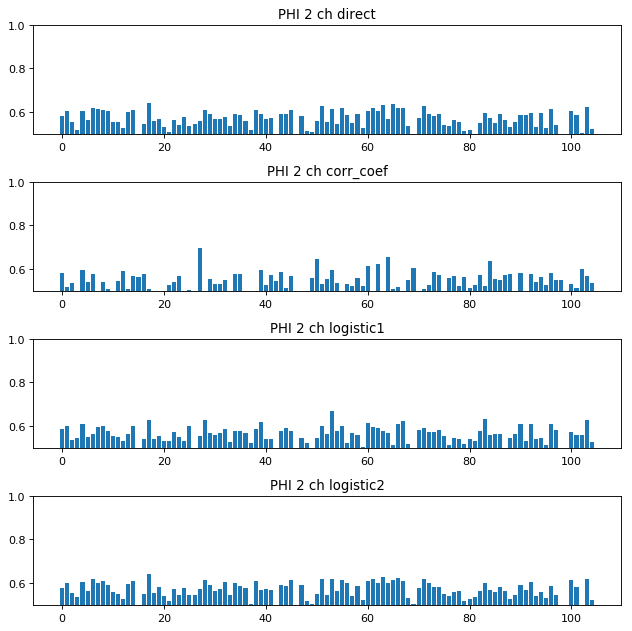

In [26]:
plot_a_fly_w_ch(2)

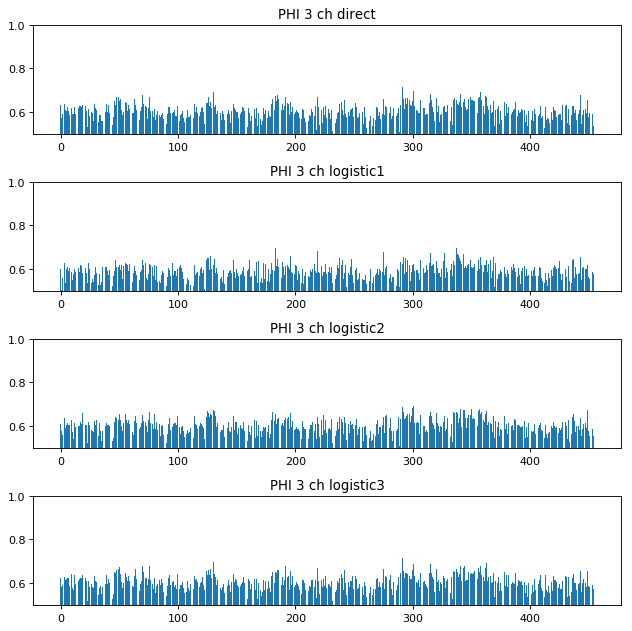

In [27]:
plot_a_fly_w_ch(3)

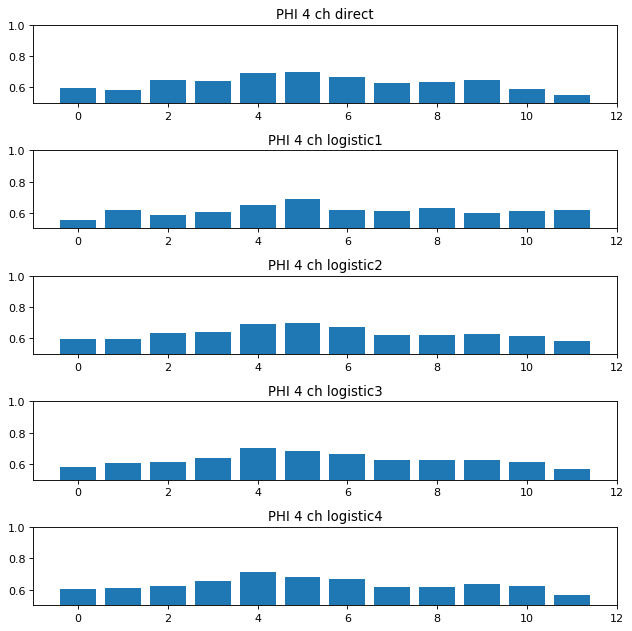

In [28]:
plot_a_fly_w_ch(4)

## Across-Trials, Within-Fly, Across-Channel Groups

This will give us 1 classification score for each fly (for each method).

Each classification set will have `n_trials * n_conds = 16` samples. Each sample will have a multidimensional independent variable, with the number of dimensions equalling the number of channel groups.

In [29]:
def group_a_ch(d, folds):
    
    grouped = d.groupby("ch_set")
    ch_groups = set(d["ch_set"])
    
    applied = grouped.apply(lambda x: x.value)
    
    xs = np.stack([applied.loc[i] for i in ch_groups], axis=1).astype(float)
    ys = grouped.apply(lambda x: x.i_cond).loc[0].astype(int) # should be same for all
    
    model = NearestCentroid()
    
    if folds == 0:
        folds = xs.shape[0]

    scores = cross_val_score(model, xs, ys, cv=folds) # leave one out cross-validation
    
    data_dict = {"score_mean": scores.mean(),
                 "score_std": scores.std(),
                 "n_samples": xs.shape[0]
                }
    
    return pd.Series(data_dict)

In [ ]:
def group_w_fly_a_ch(d):
    return group_a_ch(d, 0)

In [30]:
# %%time
# w_fly_a_ch = ddata.groupby(["method", "ch_num", "i_fly"]).apply(group_w_fly_a_ch)

CPU times: user 47.8 s, sys: 443 ms, total: 48.3 s
Wall time: 48.7 s


In [32]:
# # SAVE
# with pd.HDFStore('../data/processed/decoding.h5') as store:
#     store['w_fly_a_ch'] = w_fly_a_ch

In [33]:
def plot_w_fly_a_ch():

    fig = plt.figure(figsize=(12, 4), dpi= 80)
    
    w = 0.045
    #mid_fly = n_flies // 2 # n_flies is global
    
    i_m = 0
    
    mid_method = 13 // 2 # total number of methods is 13
    
    for ch_num in ch_nums:
        
        methods = methods_ch_nums[ch_num] # methods_ch_nums is global
        n_methods = len(methods)
    
        for i_method, method in enumerate(methods):

            d = w_fly_a_ch.loc[method, ch_num]

            scores = d.score_mean.values
            stds = d.score_std.values
            x_pos = list(map(lambda x: x + ((i_m - mid_method) * (w*1.5)), range(n_flies)))


            #if i_fly == mid_fly:
            #    tick_labels = ["{} ch {}".format(ch_num, method) for method in methods]
            #else:
            #    tick_labels = None

            plt.title("Decoding by Method by Fly")
            plt.bar(x_pos,
                scores,
                width = w,
                #tick_label = tick_labels,
                #color = [colors[r.get("ch_num") - 2] for r in r_fly],
                #yerr = stds,
                label="{}ch-{}".format(ch_num, method)
                )
            plt.ylim((0, 1)) 
            
            i_m += 1

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

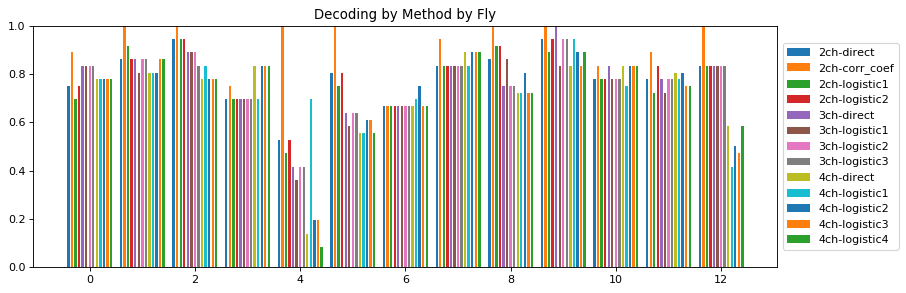

In [34]:
plot_w_fly_a_ch()

## Across-Trials, Across-Flies, Across-Channel Groups

This will give us 1 classification score (for each method).

Each classification set will have `n_trials * n_conds = 208` samples. Each sample will have a multidimensional independent variable, with the number of dimensions equalling the number of channel groups.

> It should be noted that perhaps the between-channel-number sets (i.e. between colours) are not comparable as the number of dimensions for decoding differs quite significantly (~100 for 2ch, ~400 for 3ch and only 12 for 4ch due to time constraints).

In [ ]:
def group_a_fly_a_ch(d):
    return group_a_ch(d, 3)

In [35]:
# %%time
# a_fly_a_ch = ddata.groupby(["method", "ch_num"]).apply(group_a_fly_a_ch)

CPU times: user 4.65 s, sys: 432 ms, total: 5.08 s
Wall time: 4.97 s


In [36]:
# SAVE
#with pd.HDFStore('../data/processed/decoding.h5') as store:
#    store['a_fly_a_ch'] = a_fly_a_ch

In [37]:
def plot_a_fly_a_ch():

    fig = plt.figure(figsize=(12, 4), dpi= 80)
    
    #w = 0.045
    #mid_fly = n_flies // 2 # n_flies is global
    
    i_m = 0
        
    score_list = []
    std_list = []
    tick_labels = []
    colours = []
    
    cmap=pylab.get_cmap("Set1")
    
    for ch_num in ch_nums:
        
        methods = methods_ch_nums[ch_num] # methods_ch_nums is global
        n_methods = len(methods)
    
        for i_method, method in enumerate(methods):

            d = a_fly_a_ch.loc[method, ch_num]

            scores = d.score_mean
            stds = d.score_std
            
            if "corr_coef" in method:
                colours.append(cmap(0))
            else:
                colours.append(cmap(ch_num))
            score_list.append(scores)
            std_list.append(stds)
            tick_labels.append("{}ch-{}".format(ch_num, method))
            
    plt.title("Decoding by Method")
    order = [1, -0.3] + list(range(2, 13)) # ensure corr_coef is first
    plt.bar(order,
        score_list,
        color=colours,
        yerr = std_list,
        )
    plt.xticks(order, tick_labels, rotation="vertical")
    plt.ylim((0.5, 1)) 


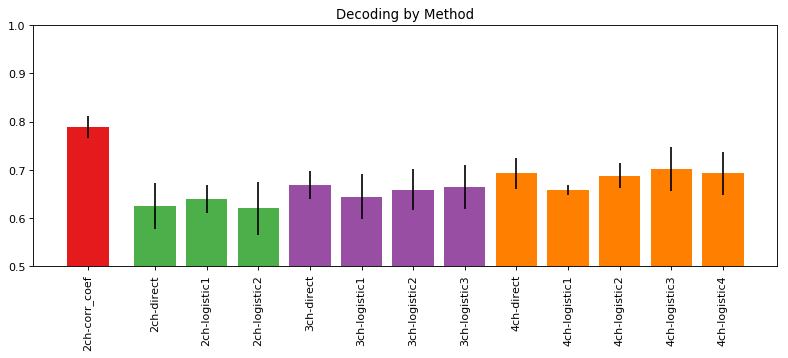

In [38]:
plot_a_fly_a_ch()